# Termpaper TECH2

## NHH Fall 2024
### **Candidate numbers: 7, 20, 35**
---

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### P.1 Preliminary data handling and cleaning
Since the data is in multiple csv files - concatenate all into a single dataframe and check for data consistency


In [2]:
# Specify variables for data handling
data_path = 'data/' # Path to data folder - change for OS
regions = ["NO2", "DE_LU"]
datasets = ["DayAheadPrices_12.1.D", "PhysicalFlows_12.1.G"]
csv_sep = "	"
start_year, end_year = 2019, 2023

def read_csvs(dataset, start_year, end_year, csv_sep):
    """ Read multiple csv files into a single pandas dataframe """
    data = pd.DataFrame()
    for year in range(start_year, end_year+1):
        for month in range(1, 13):
            file_path = f"{data_path}/{dataset}/{year}_{month:02d}_{dataset}.csv"
            try:
                df = pd.read_csv(file_path, sep=csv_sep)
                data = pd.concat([data, df], ignore_index=True)
            except FileNotFoundError:
                pass
    return data


#### P.1.1 - DayAheadPrices
- Keep relevant columns
- Keep only the two selected regions
- Reset indeces for clarity

In [3]:
# Create the dataframe for DayAheadPrices and check for consistency
dayaheadprices = pd.DataFrame()
keep_columns = ["DateTime", "ResolutionCode", "MapCode", "Price"] # Relevant columns for the analysis
# Keep only the selected MapCodes and relevant columns
dayaheadprices = pd.concat([dayaheadprices, read_csvs(datasets[0], start_year, end_year, csv_sep)])[keep_columns]
dayaheadprices = dayaheadprices.loc[dayaheadprices["MapCode"].isin(regions)]

# Reset indeces
dayaheadprices.reset_index(drop=True, inplace=True)
    
# Check for duplicates and missing values
print(f"Duplicate values: {dayaheadprices.duplicated().sum()}")
print(f"Missing values: {dayaheadprices.isnull().sum().sum()}")


Duplicate values: 0
Missing values: 0


#### P.1.2 - PhysicalFlows
- Keep only the trades between NO2 and DE_LU and vice versa


In [4]:
physicalflows = pd.DataFrame()
physicalflows = pd.concat([physicalflows, read_csvs(datasets[1], start_year, end_year, csv_sep)])

# Keep only trades between the selected regions
physicalflows = physicalflows.loc[(physicalflows["InMapCode"].isin(regions)) & (physicalflows["OutMapCode"].isin(regions))]
physicalflows.reset_index(drop=True, inplace=True)

# Check for duplicates and missing values
print(f"Duplicate values: {physicalflows.duplicated().sum()}")
print(f"Missing values: {physicalflows.isnull().sum().sum()}")


Duplicate values: 0
Missing values: 0


### *Conclusion*
Both datasets are consistent with no duplicate or missing values.

## Task 1
### The development of energy prices across the sample period
- Visualisation of energy prices in NO2 and DE_LU per hour using a line plot
- Showing the official opening time of Nordlink in Dec. 9. 2020

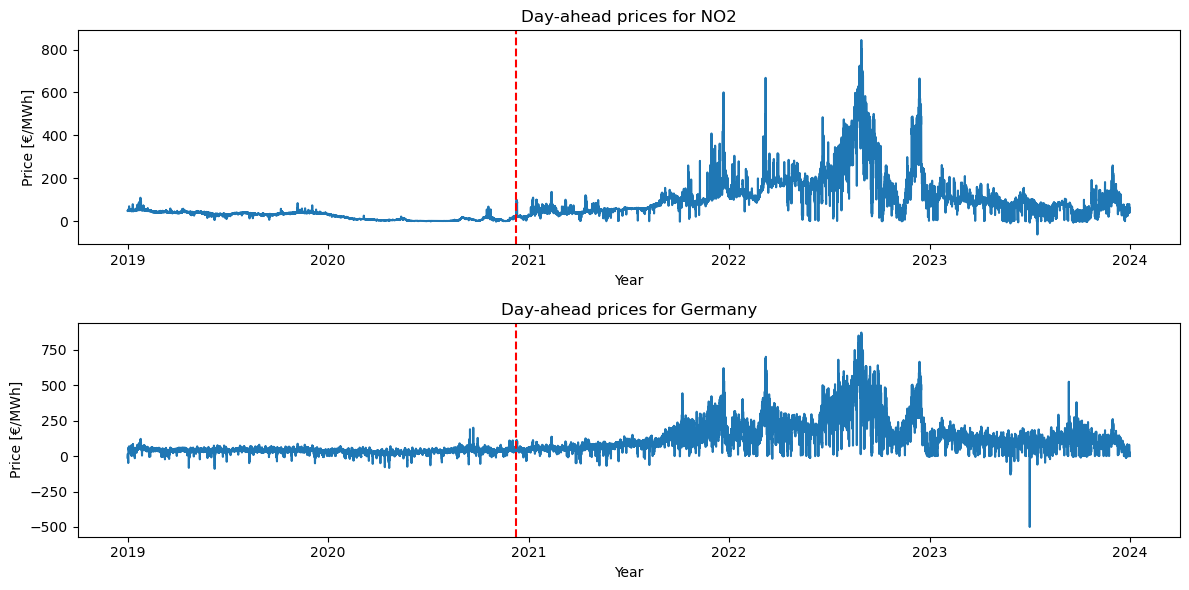

In [12]:
# Create a copy from dayaheadprices and filtering to hourly data only
dayaheadprices_hourly = dayaheadprices.loc[dayaheadprices["ResolutionCode"] == "PT60M"].copy()
# Convert DateTime to datetime object
dayaheadprices_hourly["DateTime"] = pd.to_datetime(dayaheadprices_hourly["DateTime"])

# Plot the hourly prices for the selected regions on two subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 6))
for region, ax in zip(regions, axes):
    sns.lineplot(data=dayaheadprices_hourly.loc[dayaheadprices_hourly["MapCode"] == region], x="DateTime", y="Price", ax=ax)
    ax.axvline(pd.Timestamp("2020-12-09"), color='red', linestyle='--', label='Nordlink Opening')
    if region == "DE_LU":
        ax.set_title(f"Day-ahead prices for Germany")
    else:
        ax.set_title(f"Day-ahead prices for {region}")
    ax.set_ylabel("Price [€/MWh]")
    ax.set_xlabel("Year")
plt.tight_layout()
# Save to file
plt.savefig("figure_task1.png")

### *Conclusion*
Hourly electricity prices in NO2 and Germany have increased significantly since the opening of Nordlink.  During 2022 the prices reached a maximum and remained relatively more stable during 2023, at a similar price as before the opening of Nordlink. In Germany, prices have shown a higher frequency of extreme fluctuations, both positive and negative. 
A reason why we sometimes see negative hourly electricity prices can be that there is a higher supply of electricity than demand. This might be because of periods of higher wind- or water turbine output or solar output. Additionally, during low-demand periods, typically during holidays or nighttime, there may be a higher supply than consumption, contributing to these negative price instances. 

## Task 2
### Statistics table for the day ahead price data
- Contains the mean, median, standard deviation, min and max for hourly price for each year rounded to two digits

In [6]:
# Create a year variable
dayaheadprices_hourly["Year"] = dayaheadprices_hourly["DateTime"].dt.year

# Calculate the summary statistics for the hourly prices
summary = dayaheadprices_hourly.groupby(["Year", "MapCode"])["Price"].agg(["mean", "median", "std", "min", "max"]).round(2).reset_index()
print(summary)
# Save to excel file
summary.to_excel("table_task2.xlsx", index=False)

   Year MapCode    mean  median     std     min     max
0  2019   DE_LU   37.67   38.06   15.52  -90.01  121.46
1  2019     NO2   39.26   38.81    8.23    5.86  109.45
2  2020   DE_LU   30.47   30.99   17.50  -83.94  200.04
3  2020     NO2    9.29    6.95    8.26   -1.73   99.92
4  2021   DE_LU   96.85   75.48   73.68  -69.00  620.00
5  2021     NO2   75.11   59.34   47.22   -1.97  600.16
6  2022   DE_LU  235.44  208.34  142.82  -19.04  871.00
7  2022     NO2  211.28  181.13  125.85    0.04  844.00
8  2023   DE_LU   95.18   98.02   47.58 -500.00  524.27
9  2023     NO2   79.44   80.46   36.28  -61.84  261.85


### *Conclusion*
Electricity prices have become more extreme in both NO2 and in Germany in recent years, especially following the opening of Nordlink. Average hourly prices increased rapidly, with frequent extreme values. While price trends in NO2 and Germany are relatively similar, Germany generally experiences higher prices, averaging 96.85 €/MWh compared to 75.11 €/MWh in NO2 in 2021 and 235.44 €/MWh compared to 211.81€/MWh in 2022. Germany also sees more frequent periods of negative prices, reaching as low as -500 €/MWh in 2023, indicating greater price volatility compared to the Norwegian market. 


## Task 3
### Annual sum of exports and imports of electricity in NO2 on Nordlink
- Yearly breakdown
- Nordlink only

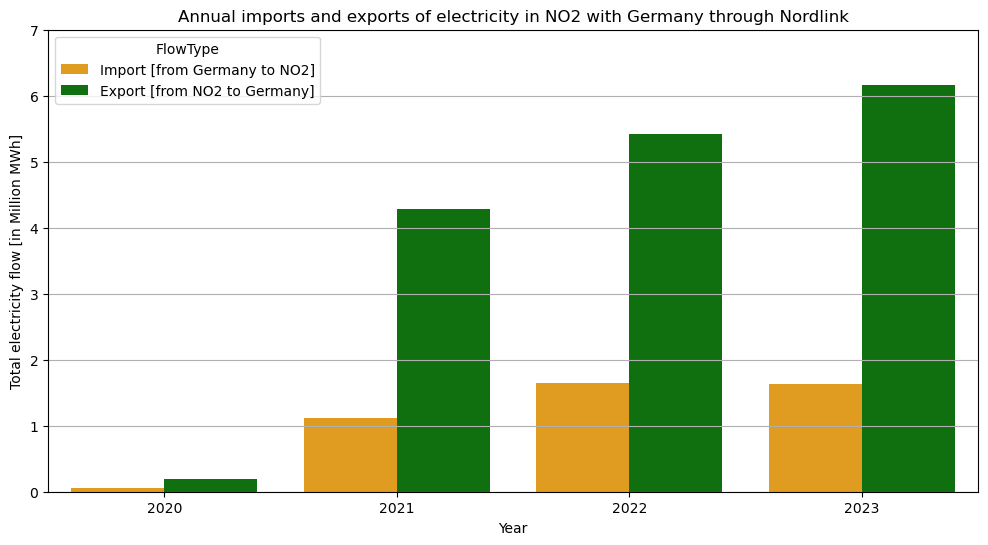

In [7]:
# Transform to datetime object and create a year variable
physicalflows["DateTime"] = pd.to_datetime(physicalflows["DateTime"])
physicalflows["Year"] = physicalflows["DateTime"].dt.year

# Calculate the import and export flows
imports, exports = physicalflows[physicalflows["InMapCode"] == "NO2"].groupby("Year")["FlowValue"].sum().reset_index(), physicalflows[physicalflows["OutMapCode"] == "NO2"].groupby("Year")["FlowValue"].sum().reset_index()
imports["FlowType"], exports["FlowType"] = "Import [from Germany to NO2]", "Export [from NO2 to Germany]"

flow_data = pd.concat([imports, exports])

# Plot the import and export flows in million MWh
plt.figure(figsize=(12, 6))
sns.barplot(data=flow_data, x="Year", y="FlowValue", hue="FlowType", palette=["orange", "green"])
plt.title("Annual imports and exports of electricity in NO2 with Germany through Nordlink") 
plt.ylabel("Total electricity flow [in Million MWh]")
plt.grid(axis='y')
plt.yticks(ticks=plt.yticks()[0], labels=[f'{int(tick/1e6)}' for tick in plt.yticks()[0]])
plt.savefig("figure_task3.png")
plt.show()


### *Conclusion*
Since the opening of Nordlink, NO2 has exported significantly more electricity to Germany than it has imported from Germany. We see from the chart that the annual sum of electricty exported from NO2 to Germany has increased by approximately 1 million MWh per year from 2021 to 2023. In the same time period, the annual sum of electricty imported to NO2 from Germnay, has been steady, with an annual sum between 1 and 2 million MWh.

## Task 4
### The weekly sum of net exports from NO2 to Germany


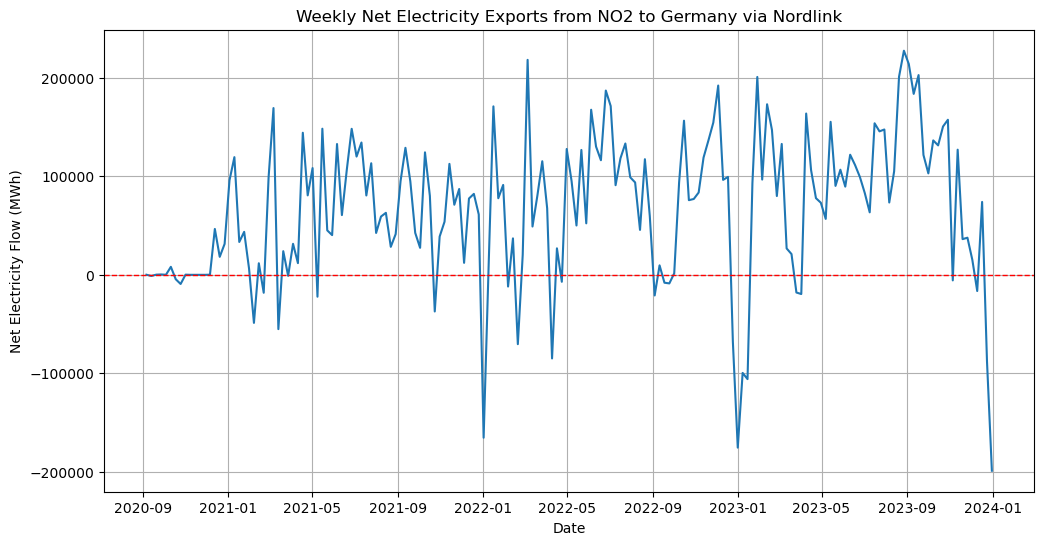

In [8]:
# Calculate the net export from NO2 to Germany
physicalflows_week = physicalflows.copy()
physicalflows_week["Week"] = physicalflows_week["DateTime"].dt.isocalendar().week
# Calculate the net export
physicalflows_week["NetExport"] = physicalflows_week.apply(lambda row: row["FlowValue"] if row["InMapCode"] == "DE_LU" else -row["FlowValue"], axis=1)
# Sample the data to weekly resolution
weekly_net_exports = physicalflows_week.resample('W', on='DateTime')['NetExport'].sum()

# Plot the weekly net exports
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(weekly_net_exports.index, weekly_net_exports.values)
ax.axhline(0, color='red', linestyle='--', linewidth=1, label='Net Export = 0')
ax.set_xlabel('Date')
ax.set_ylabel('Net Electricity Flow (MWh)')
ax.set_title('Weekly Net Electricity Exports from NO2 to Germany via Nordlink')
ax.grid(True)
plt.savefig("figure_task4.png")


### *Conclusion*
NO2 has not always exported more electricity to Germany than it has imported. There have been weeks that NO2 was the net importer of electricity and this is usually during the winter months. The negative spike in the graph in January of 2022, 2023 and 2024 shows this seasonal pattern, and can represent an increased demand for electricity in Norway during the colder months. The supply of electricity in NO2 might be insufficient to cover the need, or have a higher price than importing, which makes it beneficial to import from Germany. Hence, NO2 has been the net exporter on a seasonal basis. 


## Task 5
### Weekly sum of net exports between NO2-DE_LU and the weekly average price difference
- Contain correlation

In [ ]:
# Calculate the weekly price difference between Germany and NO2 and plot the correlation between the weekly price different and the sum of net exports that week
dayaheadprices_weekly = dayaheadprices_hourly.copy()
prices_filtered = dayaheadprices_weekly.groupby(['DateTime', 'MapCode'])['Price'].mean().reset_index()

# Pivot the data to have the prices in columns
prices_pivot = prices_filtered.pivot(index='DateTime', columns='MapCode', values='Price')

# Calculate the price difference between Germany and NO2
prices_pivot['PriceDifference'] = prices_pivot['DE_LU'] - prices_pivot['NO2']

# Resample price difference to weekly average
weekly_price_diff = prices_pivot['PriceDifference'].resample('W').mean()
# Combine weekly net exports and weekly average price difference into a single dataframe
weekly_data = pd.DataFrame({'NetExports': weekly_net_exports, 'PriceDifference': weekly_price_diff})

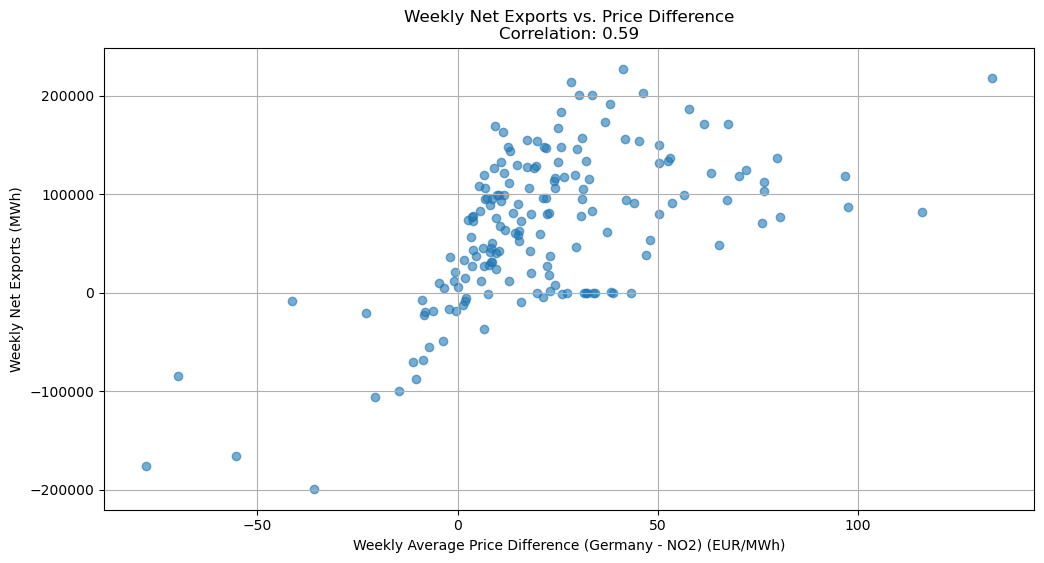

In [11]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(weekly_data['PriceDifference'], weekly_data['NetExports'], alpha=0.6)
# Calculate the correlation coefficient
correlation = weekly_data.corr().loc['PriceDifference', 'NetExports']

# Plot on a scatter plot
ax.set_xlabel('Weekly Average Price Difference (Germany - NO2) (EUR/MWh)')
ax.set_ylabel('Weekly Net Exports (MWh)')
ax.set_title(f'Weekly Net Exports vs. Price Difference\nCorrelation: {correlation:.2f}')
ax.grid(True)
fig.savefig("figure_task5.png")

### *Conclusion*
The scatter plot shows that NO2 tends to export more electricity to Germany when the price is higher in Germany compared to NO2. There are instances where this is not the case, and some where the net exports equal zero, although in the majority of cases the relationship is positive. The correlation rate: 0.59, indicates the positive relationship.

## Task 6
- Use of external tools
##### The project has relied on AI tools (GitHub Copilot and ChatGPT) to aid efficiency and speed of coding and error resolution. In detail, GitHub Copilot has been used as an IDE integrated tool to speed up the completion of syntaxes, such as commands, variables or arguments. ChatGPT was utilised for error resolving, such as to solve library dependency errors or errors with git. 